In [1]:
!pip3 install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 27.3 MB/s eta 0:00:00


In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
from torchvision import transforms
from segment_anything import sam_model_registry, SamPredictor
import os

In [2]:
# Dataset for SAM Features
class SAMFeatureDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)

        mask = np.array(mask, dtype=np.int64)
        return image, mask

In [3]:
# Data Loader Setup
images_dir = "images_png"
masks_dir = "masks_png"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = SAMFeatureDataset(images_dir, masks_dir, transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [5]:
sam_checkpoint = "sam_weights.pth"
sam_model = sam_model_registry["vit_b"](checkpoint=sam_checkpoint).to("cuda")
sam_predictor = SamPredictor(sam_model)


class SegmentationHead(torch.nn.Module):
    def __init__(self, in_features, num_classes):
        super(SegmentationHead, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_features, 256, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(256, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.conv2(x)
        return x

segmentation_head = SegmentationHead(in_features=256, num_classes=8).to("cuda")  # 8 classes in masks
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(segmentation_head.parameters(), lr=1e-4)

In [45]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix


def calculate_accuracy(pred, target):
    correct = (pred == target).float().sum()
    total = target.numel()
    accuracy = correct / total
    return accuracy

def calculate_iou(pred, target, num_classes):
    iou_list = []
    pred = pred.view(-1)
    target = target.view(-1)
    
    for i in range(num_classes):
        intersection = torch.sum((pred == i) & (target == i)).float()
        union = torch.sum((pred == i) | (target == i)).float()
        iou = intersection / (union + 1e-6)  # To avoid division by zero
        iou_list.append(iou)
    
    return np.mean(iou_list)

def calculate_dice(pred, target, num_classes):
    dice_list = []
    pred = pred.view(-1)
    target = target.view(-1)
    
    for i in range(num_classes):
        intersection = torch.sum((pred == i) & (target == i)).float()
        dice = (2 * intersection) / (torch.sum(pred == i) + torch.sum(target == i) + 1e-6)
        dice_list.append(dice)
    
    return np.mean(dice_list)

# Modified Training Loop to Compute Metrics

def train(loader, sam_predictor, segmentation_head, optimizer, criterion, epochs=5, num_classes=8):
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        epoch_iou = 0
        epoch_dice = 0
        for images, masks in loader:
            images = images.to("cuda")
            masks = masks.to("cuda")

            # Loop over the batch and process each image individually
            batch_loss = 0
            batch_accuracy = 0
            batch_iou = 0
            batch_dice = 0
            for i in range(images.size(0)):
                image = images[i:i+1]  # Select one image at a time
                mask = masks[i:i+1]  # Select corresponding mask

                # Convert the image to (H, W, C) before passing to SAM
                image = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)

                # Extract SAM features for this image
                with torch.no_grad():
                    sam_predictor.set_image(image)  # Ensure the image is in H, W, C format
                    embeddings = sam_predictor.get_image_embedding()  # (B, C, H, W)

                # Apply the segmentation head
                outputs = segmentation_head(embeddings)  # (B, C, H, W)
            
                outputs = F.interpolate(outputs, size=mask.shape[1:], mode='bilinear', align_corners=False)
                loss = criterion(outputs, mask)
                loss.backward()
                optimizer.step()
                pred = outputs.argmax(dim=1).squeeze().cpu()  # Predicted class for each pixel
                target = mask.squeeze().cpu()  # Ground truth mask
                
                accuracy = calculate_accuracy(pred, target)
                iou = calculate_iou(pred, target, num_classes)
                dice = calculate_dice(pred, target, num_classes)
                
                batch_loss += loss.item()
                batch_accuracy += accuracy.item()
                batch_iou += iou
                batch_dice += dice

            epoch_loss += batch_loss / images.size(0)
            epoch_accuracy += batch_accuracy / images.size(0)
            epoch_iou += batch_iou / images.size(0)
            epoch_dice += batch_dice / images.size(0)

        # Print metrics for each epoch
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"  Loss: {epoch_loss / len(loader)}")
        print(f"  Accuracy: {epoch_accuracy / len(loader)}")
        print(f"  Mean IoU: {epoch_iou / len(loader)}")
        print(f"  Mean Dice: {epoch_dice / len(loader)}")

# Example to call train function with metrics
train(loader, sam_predictor, segmentation_head, optimizer, criterion, epochs=10, num_classes=8)


Epoch 1/10
  Loss: 1.3069303498078124
  Accuracy: 0.5497394408321711
  Mean IoU: 0.1135480673317024
  Mean Dice: 0.14775929667795187
Epoch 2/10
  Loss: 1.3009179234955859
  Accuracy: 0.5492143028747665
  Mean IoU: 0.11460251270013516
  Mean Dice: 0.14957138927348093
Epoch 3/10
  Loss: 1.2869489191222458
  Accuracy: 0.5564257570616514
  Mean IoU: 0.1190747180404778
  Mean Dice: 0.15510240362439093
Epoch 4/10
  Loss: 1.2888086040481719
  Accuracy: 0.5545198265656468
  Mean IoU: 0.11692758626072945
  Mean Dice: 0.15212164882463355
Epoch 5/10
  Loss: 1.2956110525128648
  Accuracy: 0.5534904316634868
  Mean IoU: 0.1174788074796515
  Mean Dice: 0.1532701447357949
Epoch 6/10
  Loss: 1.291453297075954
  Accuracy: 0.5553808311277607
  Mean IoU: 0.11778813664530037
  Mean Dice: 0.15302258712773154
Epoch 7/10
  Loss: 1.29022617562703
  Accuracy: 0.5562815435204952
  Mean IoU: 0.11741957339038428
  Mean Dice: 0.15241065916825233
Epoch 8/10
  Loss: 1.291610633503246
  Accuracy: 0.5571752914507909
 

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2  # OpenCV for resizing

def segment_image(image_path, text_prompt, sam_predictor, segmentation_head):
    # Load the image
    image = np.array(Image.open(image_path).convert("RGB"))
    
    # Prepare SAM model input
    sam_predictor.set_image(image)
    
    # Get image embedding
    with torch.no_grad():
        embeddings = sam_predictor.get_image_embedding()
    
    # Use segmentation head to predict mask (for each pixel, it gives class probabilities)
    outputs = segmentation_head(embeddings)  # Shape: (1, num_classes, H, W)
    
    # Get predicted class (argmax along class dimension)
    predicted_class = outputs.argmax(dim=1).squeeze(0).cpu().numpy()  # Shape: (H, W)
    
    return image, predicted_class


In [51]:

image, output_mask = segment_image("images_png/2492.png", "building", sam_predictor, segmentation_head)

output_mask_resized = cv2.resize(output_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

mask_color = np.zeros_like(image)
mask_color[output_mask_resized == 2] = [255, 0, 0]  # For class '1', make the mask red (you can customize this)

alpha = 0.5  # Control the transparency level of the mask
overlay_image = np.copy(image)
overlay_image = (alpha * mask_color + (1 - alpha) * overlay_image).astype(np.uint8)


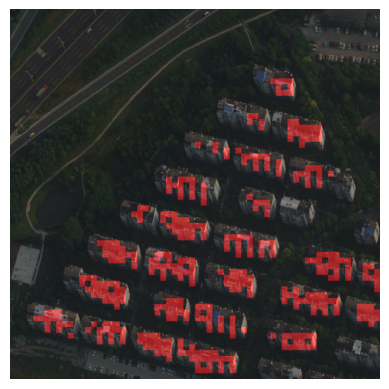

In [52]:
plt.imshow(overlay_image)
plt.axis('off')  # Turn off axis
plt.show()

In [20]:
import torch

save_path = "trained_model.pth"

torch.save({
    'segmentation_head_state_dict': segmentation_head.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 10,  
}, save_path)

print(f"Model saved to {save_path}")

Model saved to /kaggle/working/trained_model.pth
